In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
#from preprocessing.preprocessing_csv import Preprocessing_CSV_Seniority
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
#from preprocessing.preprocessing_json import Preprocessing_JSON_annotated_Seniority
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
import json
from imblearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import joblib

#### Preprocessing CSV

In [17]:
class Preprocessing_CSV():
    def __init__(self, file_path: str):
        self.file_path = file_path
        self.df: pd.DataFrame | None = None

        # Label and Text
        self.X: pd.Series = None
        self.y: pd.Series = None

        # Optional: keep raw versions too
        self.X_raw: pd.Series | None = None
        self.y_raw: pd.Series | None = None

        self.read_csv()

    @staticmethod
    def clean_text(text: str) -> str:
        """Lowercase, strip, replace - and / with spaces."""
        return str(text).lower().strip().replace("-", " ").replace("/", " ")

    def read_csv(self):
        """Reads CSV and exposes X (cleaned text) and y (raw text labels)."""
        self.df = pd.read_csv(self.file_path)

        required_cols = {"text", "label"}
        if not required_cols.issubset(self.df.columns):
            raise ValueError("Wrong file mate :( Expected columns: text, label")

        # Raw
        self.X_raw = self.df["text"].astype(str)
        self.y_raw = self.df["label"].astype(str)

        # Cleaned + labels as strings
        self.X = self.X_raw.apply(self.clean_text)
        self.y = self.y_raw

    def label_distribution(self) -> pd.Series:
        """Quick check of label counts."""
        if self.y is None:
            return pd.Series(dtype=int)
        return self.y.value_counts()

#### Preprocessin JSON

In [18]:
class Preprocessing_JSON_annotated_Seniority:
    """
    Loads an annotated JSON file (list of persons, each a list of jobs).
    Keeps ONLY the latest ACTIVE job per person (by startDate).
    Returns:
      - self.X: pd.Series of cleaned positions (text)
      - self.y: pd.Series of raw string labels (seniority)  # NOT encoded
      - self.df: DataFrame with columns ["text", "label"]
    """

    def __init__(self, path: str):
        self.path = path
        self.df: pd.DataFrame | None = None
        self.X: pd.Series | None = None
        self.y: pd.Series | None = None

        self.read_json()

    @staticmethod
    def _parse_year_month(s):
        """Expects 'YYYY-MM' -> (year, month) or None."""
        if not isinstance(s, str) or len(s) < 7:
            return None
        try:
            year, month = s.split("-")
            return int(year), int(month)
        except Exception:
            return None

    @staticmethod
    def clean_text(text: str) -> str:
        return str(text).lower().strip().replace("-", " ").replace("/", " ")

    def read_json(self):
        with open(self.path, "r", encoding="utf-8") as f:
            data = json.load(f)

        rows = []

        for person_jobs in data:
            if not isinstance(person_jobs, list):
                continue

            active_jobs = []
            for job in person_jobs:
                if not isinstance(job, dict):
                    continue
                if job.get("status") != "ACTIVE":
                    continue

                start = self._parse_year_month(job.get("startDate"))
                if start is None:
                    continue

                active_jobs.append((start, job))

            if not active_jobs:
                continue

            _, job = max(active_jobs, key=lambda x: x[0])

            position = job.get("position")
            seniority = job.get("seniority")

            if not position or not seniority:
                continue

            rows.append(
                {"text": self.clean_text(position), "label": str(seniority)}
            )

        self.df = pd.DataFrame(rows)
        if self.df.empty:
            raise ValueError("No valid samples found in JSON")

        self.X = self.df["text"].astype(str)
        self.y = self.df["label"].astype(str)

        print(f"[JSON] Loaded {len(self.df)} samples from {self.path}")

#### Pipeline:

1. Load and Prepare CSV Data
2. Load and Prepare not-annotated.json data
3. Concatenate and Train-Test Split
4. Bow and Logistic Regression with Hyperparam Search and 5 Fold CV
5. Test on test set
6. Test on annotated.json -> maybe with .predict_proba()

In [19]:
# 1. Load and Prepare CSV Data
data = Preprocessing_CSV(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/seniority-v2.csv"
)

X = data.X
y = data.y

In [20]:
# 2. Load and Prepare not-annotated.json Data
not_annotated_data = pd.read_csv("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/labeled_not_annotated.csv")
X_not_annotated = not_annotated_data["position"].astype(str).apply(data.clean_text)
y_not_annotated = not_annotated_data["seniority"].astype(str)

In [21]:
# 3. Concatenate and Train/Test split
X_concat = pd.concat([X, X_not_annotated], ignore_index=True)
y_concat = pd.concat([y, y_not_annotated], ignore_index=True)

ordinal_labels = ["Junior", "Professional", "Senior", "Lead", "Management", "Director"]
encoder = OrdinalEncoder(categories=[ordinal_labels], handle_unknown="use_encoded_value", unknown_value=-1)
y_encoded = encoder.fit_transform(y_concat.values.reshape(-1,1)).flatten()

print("Combined X:", X_concat.shape)
print("Combined y:", y_encoded.shape)
print("Unknown labels encoded as -1:", (y_encoded == -1).sum())
print(y_concat.value_counts())


Combined X: (9732,)
Combined y: (9732,)
Unknown labels encoded as -1: 0
Senior          3897
Lead            3547
Director         984
Management       817
Junior           476
Professional      11
Name: count, dtype: int64


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_concat, y_encoded, test_size=0.2, stratify=y_encoded)

In [23]:
# 4. BOW and Logistic Regression with Hyperparam Search and 5 fold CV

pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(ngram_range=(1, 2))),
    ("ros", RandomOverSampler(random_state=123)),
    ("clf", LogisticRegression(max_iter=2000))
])

parameters = {
    "tfidf__min_df": [1, 2, 3],
    "tfidf__max_df": [0.9, 0.95, 1.0],
    "tfidf__sublinear_tf": [True, False],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "clf__C": [0.1, 1, 10],
    "clf__solver": ["liblinear"],
    "clf__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=parameters,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params: {'clf__C': 10, 'clf__class_weight': None, 'clf__solver': 'liblinear', 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Best CV score: 0.8158379668335053


In [24]:
# 5. Test on test-set

csv_prediction = best_model.predict(X_test) # Auch predict_proba() probieren
print("Accuracy:", accuracy_score(y_test, csv_prediction))
print(
    classification_report(
        y_test,
        csv_prediction,
        target_names=ordinal_labels)
)

Accuracy: 0.9527478171545968
              precision    recall  f1-score   support

      Junior       0.90      0.81      0.85        95
Professional       0.40      1.00      0.57         2
      Senior       0.99      0.94      0.96       780
        Lead       0.95      0.98      0.97       710
  Management       0.83      0.94      0.89       163
    Director       0.97      0.98      0.98       197

    accuracy                           0.95      1947
   macro avg       0.84      0.94      0.87      1947
weighted avg       0.96      0.95      0.95      1947



In [25]:
# 6. Test on annotated.json

annotated_json_data = Preprocessing_JSON_annotated_Seniority(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json",
)

X_annotated = annotated_json_data.X
y_annotated = annotated_json_data.y

y_annotated_encoded = encoder.transform(y_annotated.values.reshape(-1,1)).flatten()


#X_annotated_bow = bow.transform(X_annotated)

[JSON] Loaded 457 samples from /Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json


In [26]:
predict_annotated = best_model.predict(X_annotated)

print(f"Accuracy on annotated.json: {accuracy_score(y_annotated_encoded, predict_annotated)}")

print(
    classification_report(
        y_annotated_encoded,
        predict_annotated,
        target_names=ordinal_labels,
        zero_division=0
    )
)

Accuracy on annotated.json: 0.4551422319474836
              precision    recall  f1-score   support

      Junior       0.14      0.40      0.21        10
Professional       0.14      0.01      0.02       154
      Senior       0.25      0.90      0.39        39
        Lead       0.47      0.67      0.55        97
  Management       0.83      0.60      0.70       133
    Director       0.56      0.92      0.70        24

    accuracy                           0.46       457
   macro avg       0.40      0.58      0.43       457
weighted avg       0.44      0.46      0.40       457



<Figure size 12000x12000 with 0 Axes>

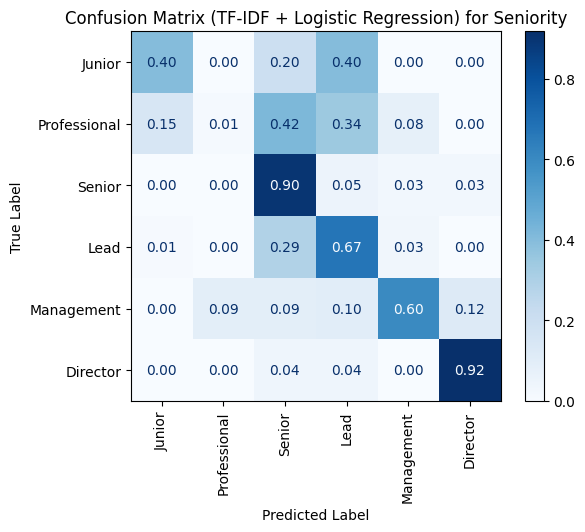

In [27]:
cm_norm = confusion_matrix(
    y_annotated_encoded,
    predict_annotated,
    normalize="true"
)

plt.figure(figsize=(20, 20), dpi=600)

display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=ordinal_labels)
display.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")

plt.title("Confusion Matrix (TF-IDF + Logistic Regression) for Seniority")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("plots/cm_tfidf_seniority.png", bbox_inches="tight")
plt.show()

In [28]:
# 7. Use Probability to improve


def predict_with_threshold(pipe, X_text, encoder, ordinal_labels, thr=0.55):
    """
    If predicted class ∈ {Junior, Senior, Lead} but proba < thr -> set to Professional.
    Returns encoded predictions.
    """
    proba = pipe.predict_proba(X_text)
    pred = pipe.predict(X_text).copy()  # encoded labels

    # Mapping label name -> encoded id based on the encoder's fixed order
    name2id = {name: i for i, name in enumerate(ordinal_labels)}

    target_ids = {name2id["Junior"], name2id["Senior"], name2id["Lead"]}
    prof_id = name2id["Professional"]

    # proba columns correspond to clf.classes_ (NOT necessarily 0..5 order)
    clf = pipe.named_steps["clf"]
    classid_to_col = {cid: j for j, cid in enumerate(clf.classes_)}

    for i, cid in enumerate(pred):
        if cid in target_ids:
            p = proba[i, classid_to_col[cid]]
            if p < thr:
                pred[i] = prof_id

    return pred


# ---- Your annotated.json evaluation with threshold ----
thr = 0.65  # try 0.5, 0.55, 0.6

predict_annotated_thr = predict_with_threshold(
    best_model,
    X_annotated,
    encoder,
    ordinal_labels,
    thr=thr
)

print(f"Accuracy on annotated.json (thr={thr}):",
      accuracy_score(y_annotated_encoded, predict_annotated_thr))

print(
    classification_report(
        y_annotated_encoded,
        predict_annotated_thr,
        target_names=ordinal_labels,
        zero_division=0
    )
)

Accuracy on annotated.json (thr=0.65): 0.5470459518599562
              precision    recall  f1-score   support

      Junior       0.13      0.30      0.18        10
Professional       0.52      0.42      0.46       154
      Senior       0.27      0.79      0.41        39
        Lead       0.82      0.51      0.62        97
  Management       0.83      0.60      0.70       133
    Director       0.56      0.92      0.70        24

    accuracy                           0.55       457
   macro avg       0.52      0.59      0.51       457
weighted avg       0.65      0.55      0.57       457



In [29]:
for thr in [0.4, 0.5, 0.55, 0.6, 0.65]:
    pred_thr = predict_with_threshold(best_model, X_annotated, encoder, ordinal_labels, thr=thr)
    print(thr, "macro F1:", f1_score(y_annotated_encoded, pred_thr, average="macro"))


0.4 macro F1: 0.4361051299785874
0.5 macro F1: 0.4471403903000087
0.55 macro F1: 0.44899015941015447
0.6 macro F1: 0.4641516847618381
0.65 macro F1: 0.5125508515577714


In [30]:
# 7. Save Model
#joblib.dump(best_model, "models/tf_idf_seniority.joblib")